# U.S. Accidents

The goal of the project is to build a machine learning algorithm that will be able to predict the amount of accidents for the first quarter of 2021.  First I will import some comom use libraries.

## Main Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings('ignore')

## The Data

Now I will import the datasets.  I will import the state dataset because it is set up for use.  The first_quarters dataset will have the info I need for the final evaluation.  I am also importing the original df just in case I may need to change something, though I do not necessarily plan to use it.

In [3]:
df = pd.read_csv("df.csv", index_col = 'Date')
df.drop(df.columns[0], axis = 1, inplace = True)

In [4]:
state = pd.read_csv("state.csv", index_col = 'Date', parse_dates = True)
state.index.freq = 'D'

In [5]:
first_quarters = pd.read_csv("first_quarters.csv")
first_quarters.drop(first_quarters.columns[0], axis = 1, inplace = True)

## Machine Learning

The machine learning method I will use will be the AutoRegression Integrated Moving Average (ARIMA) method.  Though there are multiple features, utilizing the ARIMA model will be simpler and a quicker method to achieve the goal of this project.  The Idea will be to perform the model for each individual state all at once.

### Stationarity

Checking for stationarity will help in determining whether to use the seasonal option in the ARIMA model.  In case some states are not stationary, I will transform the dataset to become stationary by utilizing the .diff() method.

I will uilize the adfuller test to check for stationarity.  The adfuller test is a hypothesis test 

In [6]:
from statsmodels.tsa.stattools import adfuller

In [7]:
num = 0

for i in state.columns:
    result = adfuller(state[i])
    if result[1] >= 0.05:
        num += 1

print(f"There are {num} non-stationary datasets.")

There are 19 non-stationary datasets.


Since there are some states that did not pass the adfuller test, I will differentiate the dataset to try and make it stationary.  In theory I would do this procedure as many times as necessary.  However, I do not believe I should need more than 2 or 3 times.

In [8]:
state_differentiated = state.diff()
state_differentiated = state_differentiated.dropna()

In [9]:
num = 0

for i in state_differentiated.columns:
    result = adfuller(state_differentiated[i])
    if result[1] >= 0.05:
        num += 1
        
if num == 0:
    print("The dataset is stationary.")
else:
    print(f"There are {num} non-stationary datasets.")

The dataset is stationary.


Great news!  The data became stationary after only one differentiation.  The next step I will do is to split the differentiated test into train and test data.

### Test Train Split

Ideally I would use about 80% of the data as the training data and 20% of it as the testing data.  Since I noticed some trends at the year 2020, specially towards the end of that year, I will only utilize the months of November and December as my test data and the remaining for training.

In [10]:
x = int(len(state_differentiated) * 0.85)

In [11]:
state_differentiated.iloc[:x].tail(1)

,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
Date,,,,,,,,,,,,,,,,,,,,,
2020-07-19,-5.0,0.0,0.0,20.0,-6.0,1.0,0.0,2.0,-14.0,-10.0,...,0.0,5.0,-8.0,-4.0,-17.0,0.0,-2.0,3.0,0.0,0.0


In [12]:
train = state_differentiated.loc[:"2020-10-31"]
test = state_differentiated.loc["2020-11-01":]

In [13]:
train.tail(1)

,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-31,-57.0,-8.0,-51.0,-138.0,-19.0,-3.0,-9.0,-5.0,-157.0,-13.0,...,0.0,-43.0,-146.0,-29.0,-69.0,1.0,-25.0,-11.0,-2.0,0.0


In [14]:
test.head(1)

,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-01,-1.0,-2.0,22.0,-69.0,-3.0,-21.0,-5.0,1.0,-99.0,-2.0,...,0.0,-38.0,-19.0,-11.0,7.0,-1.0,-8.0,0.0,-8.0,0.0


### Order

Since I am using the ARIMA model, I will utilize the auto_arima method to find which order of p, d, and q to use for each of the states in the dataset.  Those orders will be put in a dictionary with the state as the key.

In [15]:
from pmdarima import auto_arima
from tqdm import tqdm # To keep track of the loops progress

In [16]:
cols = state.columns

In [17]:
orders = {}

for i in tqdm(cols):
    result = auto_arima(state_differentiated[i], maxiter = 1000, start_p = 0, 
                        start_q = 0, max_p = 7, max_q = 7, seasonal = False)
    orders.update({i:result.order})

100%|██████████| 49/49 [44:39<00:00, 54.68s/it]  


### Model

The main reason I am using the ARIMA model for this project is because that is the model that would require the least amount of computing power given the data and it is also the model that would not require as much time to perform the training and the fitting.

In [18]:
from statsmodels.tsa.arima_model import ARIMA

In [19]:
# Much like the orders, I will also same the model and the results as dictionaries.

model = {} # Creating a blank dictionary for the model
result = {} # Creating a blank dictionary for the result

for i in tqdm(cols):
    model.update({i:ARIMA(train.loc[:,i], order = orders[i])}) # Adding each model's key and value to the model dictionary
    result.update({i:model[i].fit()}) # Adding each model's key and value to the result dictionary

  0%|          | 0/49 [00:00<?, ?it/s]C:\Users\soccershowmsn\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
  2%|▏         | 1/49 [00:36<29:23, 36.75s/it]C:\Users\soccershowmsn\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\soccershowmsn\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 29%|██▊       | 14/49 [01:25<00:49,  1.40s/it]C:\Users\soccershowmsn\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 33%|███▎      | 16/49 [01:45<02:45,  5.02s/it]C:\Users\soccershowmsn\anaconda3\lib

### Predictions

To avaliate the model I will first predict the results for the same 2 months (61 days) that I had set aside for the testing data and then compare that to the testing data using the mean absolute error.  My thinking here is to see if the predicted data's average is within range of the actual mean for the same period.  Since the mean absolute error gives me the distance from the mean of the predicted to the mean of the actual data, I would want to see how that distance can be compared to the standard deviation.

The first step is to make the prediction.

In [20]:
# The prediction will be saved as a list

pred = []

start_date = "2020-11-01"
end_date = "2020-12-31"

for i in tqdm(cols):
    pred.append(result[i].predict(start = start_date, end = end_date))

100%|██████████| 49/49 [00:00<00:00, 278.58it/s]


In [21]:
# Making a dataframe with the predicted values

prediction = pd.DataFrame(pred).T
prediction.columns = cols

In [22]:
prediction.head()

,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
2020-11-01,3.322745,4.200956,-4.531131,-125.612127,8.156479,-18.014600,-1.271133,2.766484,-36.201587,24.650278,...,0.243320,-24.389017,17.655991,3.941265,7.609669,-0.516132,-7.516465,4.151696,-2.897016,0.068447
2020-11-02,30.783790,6.636268,26.827907,-2.049894,6.877967,-2.541200,-0.244168,0.531260,48.403191,-1.562394,...,0.086118,74.161037,149.398698,8.730330,18.254715,-0.046897,2.745964,2.370041,-0.297261,0.005399
2020-11-03,6.465988,4.129317,13.724894,21.037451,0.626567,-3.408455,-0.041583,0.001548,18.891928,-9.449590,...,0.035152,12.092789,-6.887586,1.689970,-7.272893,-0.000191,2.532323,3.890837,0.608672,-0.000233
2020-11-04,2.127362,2.677430,-5.941597,-2.252328,-1.264148,11.757882,-0.001621,0.001548,-39.098749,17.377414,...,0.036389,3.425632,-15.894814,3.722753,-0.139323,-0.000191,-0.227758,2.479139,0.072708,-0.000233
2020-11-05,6.037947,0.786654,6.324766,7.264606,-0.581522,9.180937,0.006263,0.001548,6.460406,-6.480545,...,0.008297,12.666907,-37.518477,-1.143615,40.021240,-0.000191,8.017715,-0.793147,-0.060056,-0.000233


Since I used differentiated data to train the model, I need to reverse the predicted values in my next step to find the final prediction values.

In [23]:
l = len(prediction)

In [24]:
# Reversing the differentiation for the predicted values

final_prediction = state.iloc[-l-1] + prediction.cumsum()

final_prediction = state.iloc[-l-1] + rewind_prediction.cumsum()

In [25]:
final_prediction.head()

,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
2020-11-01,42.322745,21.200956,46.468869,716.387873,18.156479,33.985400,11.728867,4.766484,437.798413,74.650278,...,0.243320,75.610983,260.655991,32.941265,170.609669,0.483868,25.483535,4.151696,7.102984,0.068447
2020-11-02,73.106535,27.837224,73.296775,714.337979,25.034446,31.444199,11.484699,5.297744,486.201604,73.087885,...,0.329438,149.772020,410.054689,41.671596,188.864384,0.436971,28.229499,6.521737,6.805722,0.073845
2020-11-03,79.572523,31.966540,87.021670,735.375430,25.661013,28.035744,11.443116,5.299292,505.093531,63.638295,...,0.364590,161.864809,403.167103,43.361566,181.591491,0.436780,30.761822,10.412574,7.414394,0.073613
2020-11-04,81.699885,34.643971,81.080073,733.123102,24.396865,39.793627,11.441495,5.300840,465.994783,81.015709,...,0.400979,165.290440,387.272289,47.084319,181.452168,0.436589,30.534064,12.891712,7.487102,0.073380
2020-11-05,87.737832,35.430624,87.404839,740.387708,23.815343,48.974563,11.447758,5.302388,472.455189,74.535163,...,0.409276,177.957347,349.753812,45.940704,221.473408,0.436399,38.551779,12.098565,7.427046,0.073147


In [26]:
# Gathering the actual, non-differentiated, data for the same time period of the test and predicted datasets

state_test = state.loc['2020-11-01':]

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [28]:
mae = {}

for i in cols:
    val = mean_absolute_error(state_test[i], final_prediction[i])
    mae.update({i:val})

I will now save the mean absolute error into a dataframe.  I will also add the average value of the original dataframe during the same period as well as its standard deviation to the same dataframe.

In [29]:
res = pd.DataFrame(list(mae.items()), index = mae.keys(), columns = ['State', 'MAE']).drop('State', axis = 1)
res['Original St. D.'] = state_test.std()
res['Original Mean'] = state_test.mean()

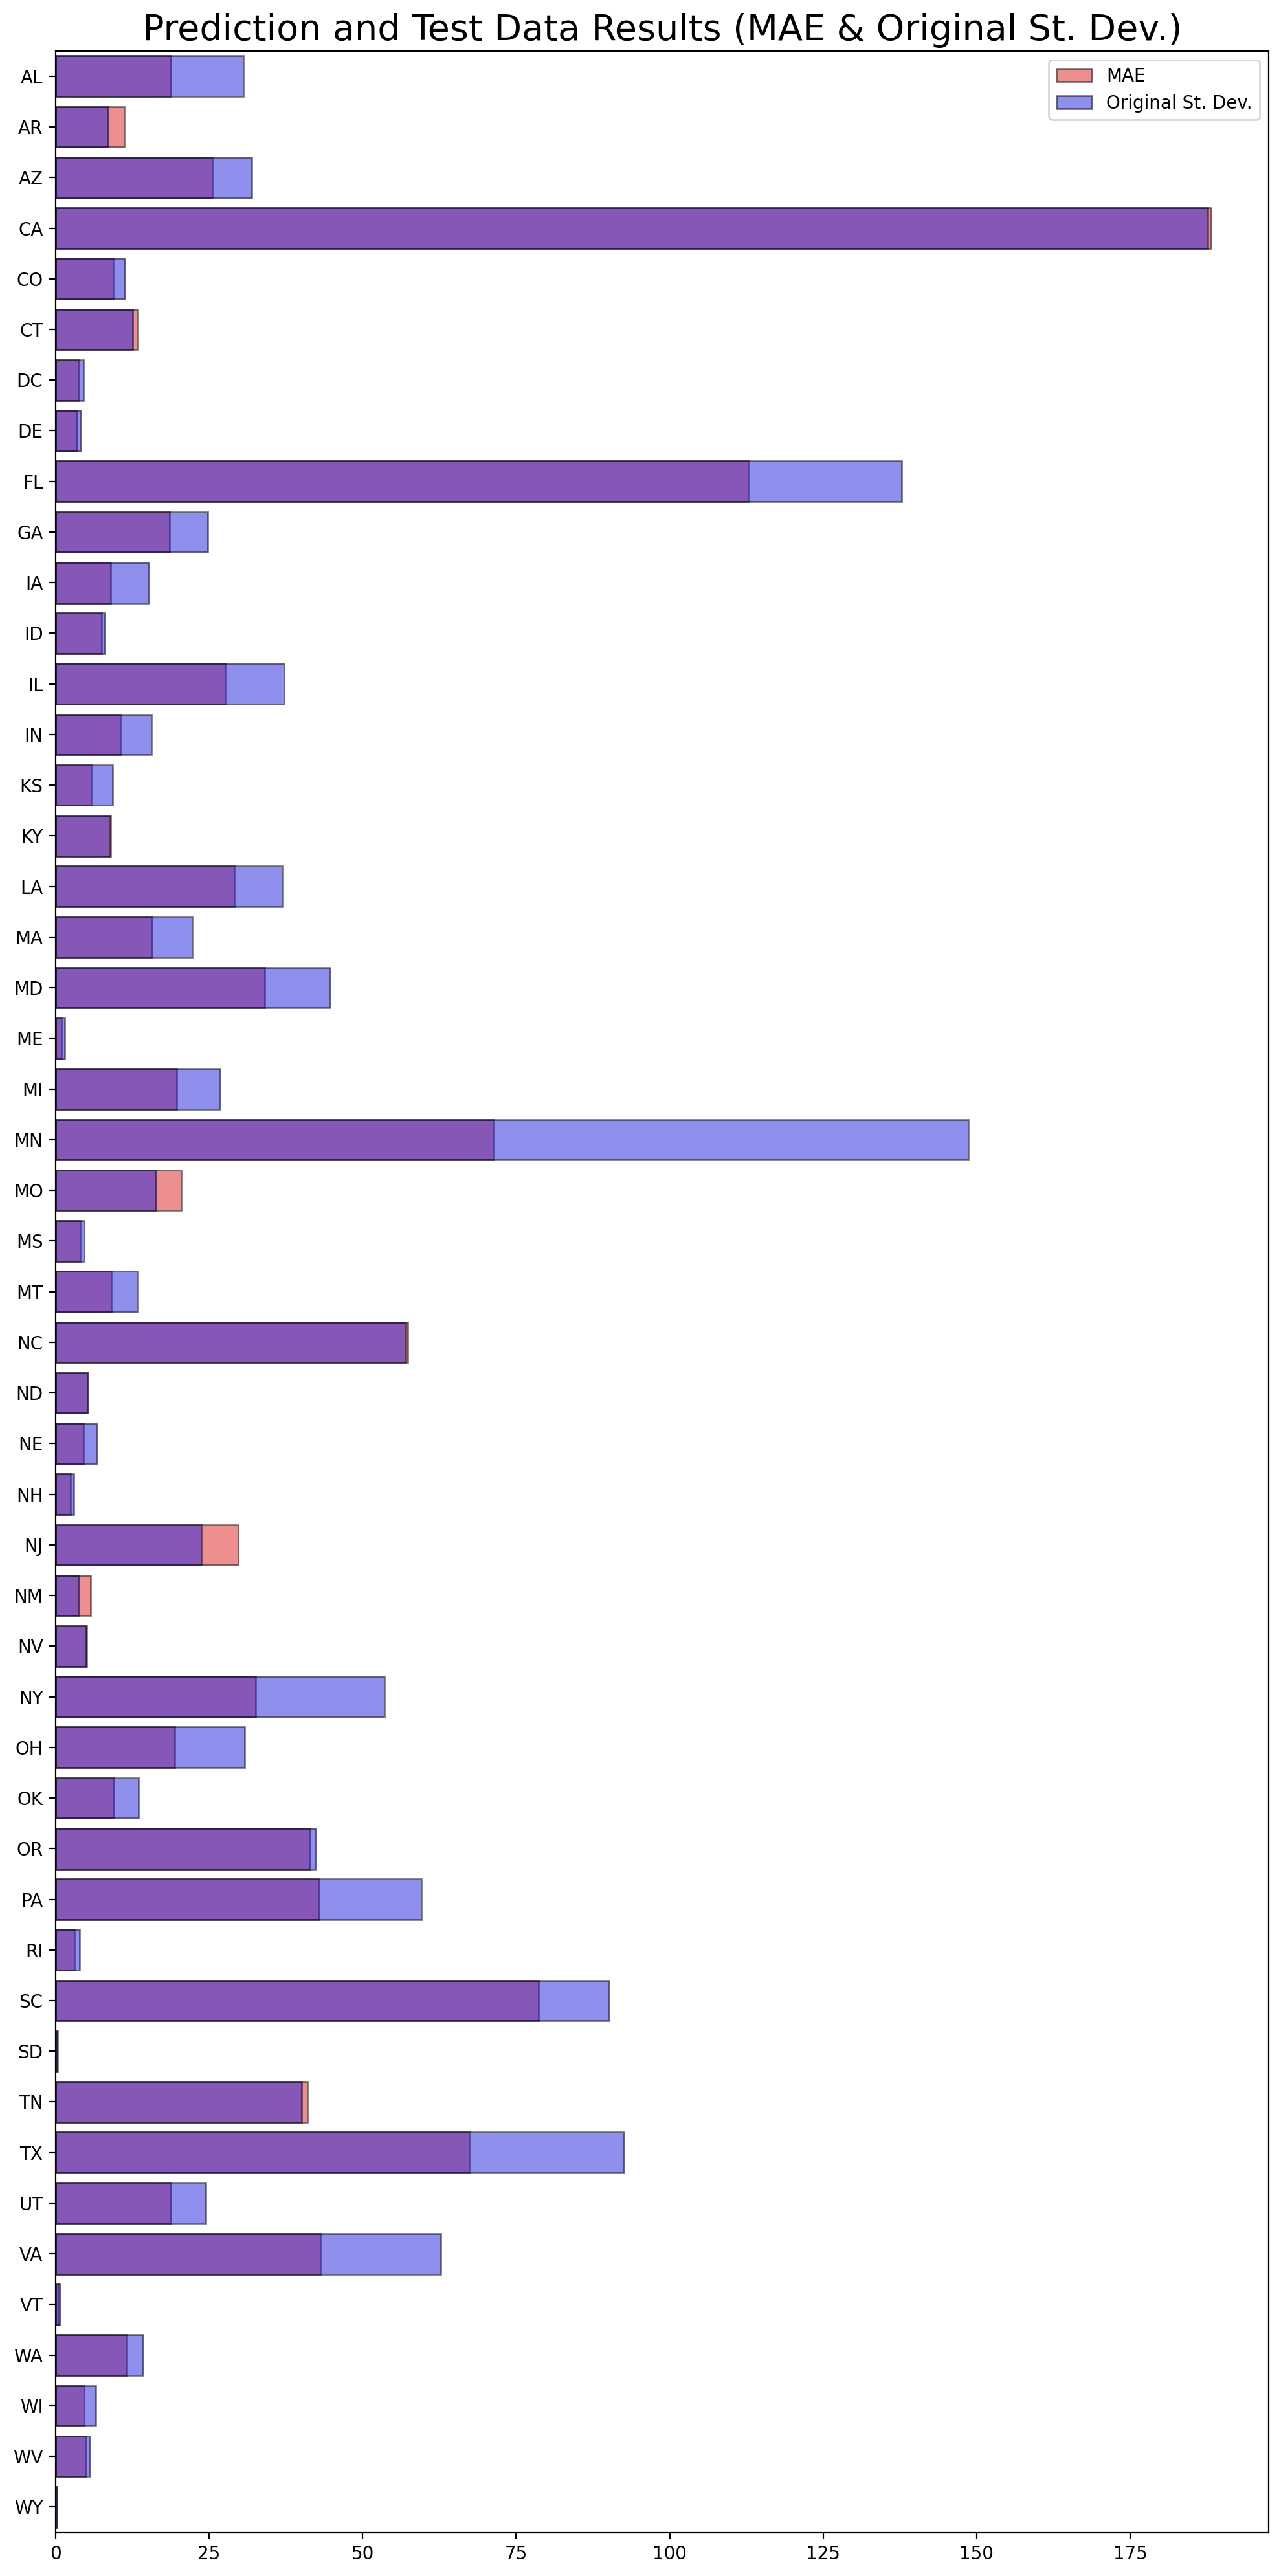

In [30]:
plt.figure(figsize = (10, 20), dpi = 200)

sns.barplot(y = res.index, x = res['MAE'], color = 'r', edgecolor = 'k', alpha = 0.5, label = 'MAE')
sns.barplot(y = res.index, x = res['Original St. D.'], color = 'b', edgecolor = 'k', alpha = 0.5, label = 'Original St. Dev.')

plt.legend()
plt.title('Prediction and Test Data Results (MAE & Original St. Dev.)', size = 20)
plt.xlabel(None)

plt.tight_layout()
plt.savefig("figures/MAE_Original_St_Dev.jpg")
plt.show()

The results indicates that most of the average of the predicted values are less than a standard deviation difference from the average of the original data in the same time period.  The states for which the average predicted value was larger than the standard deviation, the difference does not seem to be too great.  To be sure, I will create the same graph, but now using the original mean in the place of the original standard deviation.

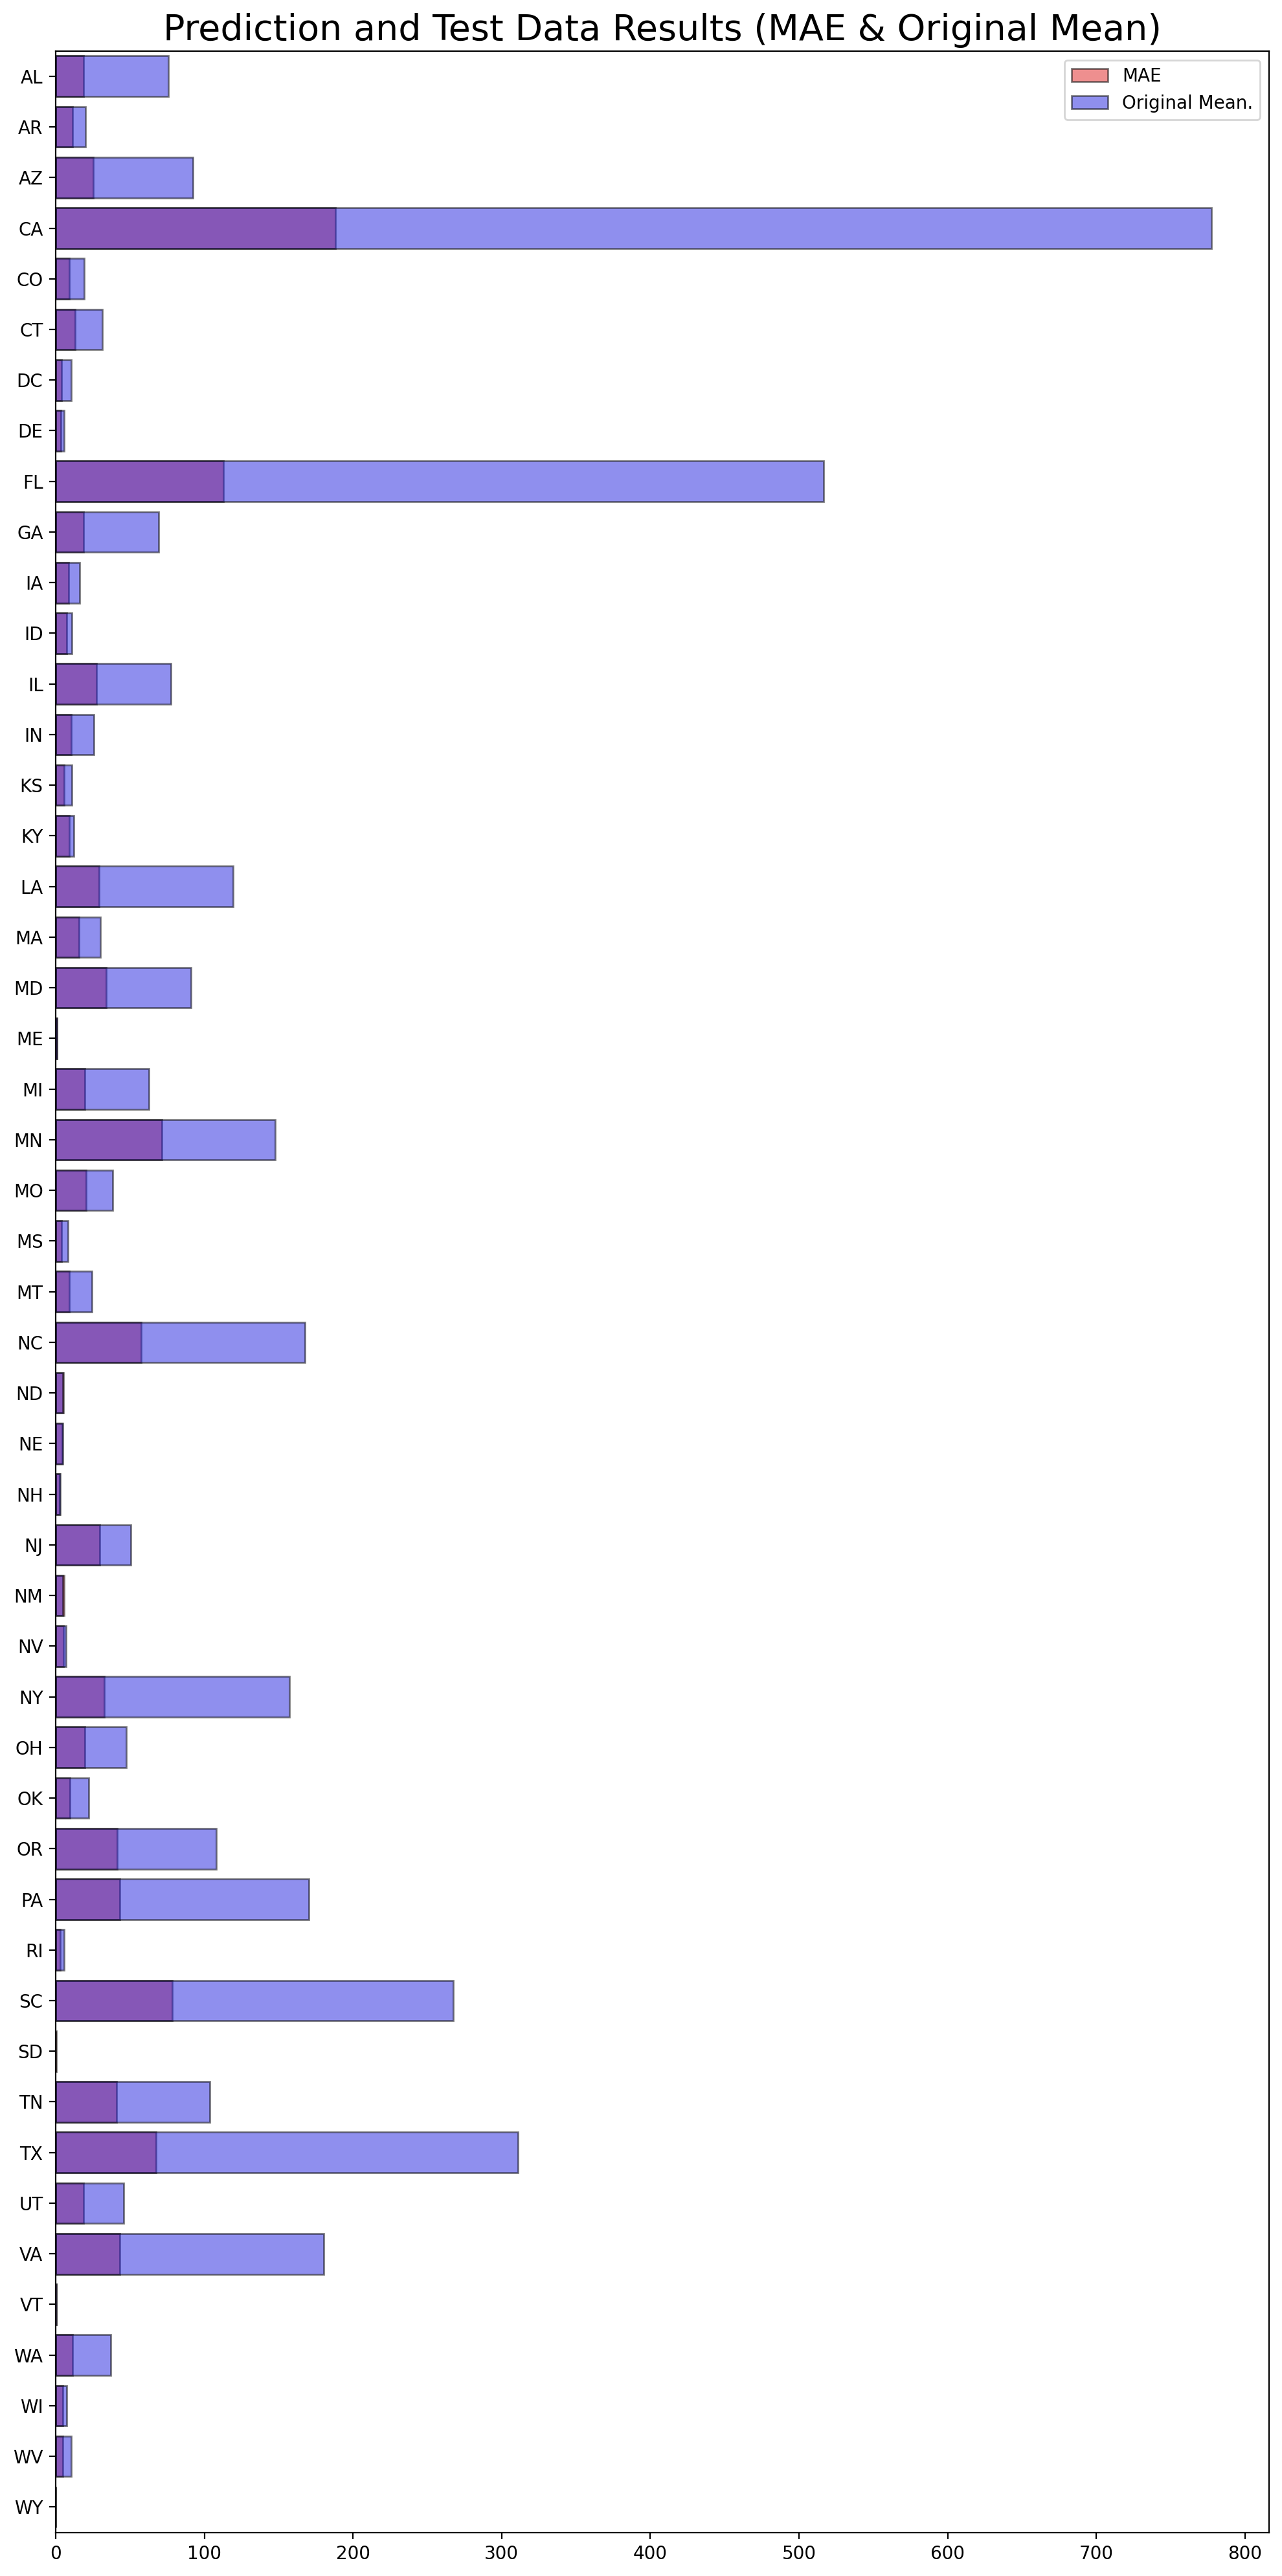

In [31]:
plt.figure(figsize = (10, 20), dpi = 200)

sns.barplot(y = res.index, x = res['MAE'], color = 'r', edgecolor = 'k', alpha = 0.5, label = 'MAE')
sns.barplot(y = res.index, x = res['Original Mean'], color = 'b', edgecolor = 'k', alpha = 0.5, label = 'Original Mean.')

plt.legend()
plt.title('Prediction and Test Data Results (MAE & Original Mean)', size = 20)
plt.xlabel(None)

plt.tight_layout()
plt.savefig("figures/MAE_Original_Mean.jpg")
plt.show()

As expected, the mean absolute error is much lower in for all the states, in some cases very lower.  That indicates that the difference of the means for the original dataset and the predicted is quite small.  Since the intention of the project is to forecast the first quarter of 2021, these results serves to show that the model can likely produce good results.

### Forecasting

I will now use the model to forecast the first quarter of 2021.  the forecast starts on January first and ends in March 31.  That means it will forecast 5 months from the ending of the training data.

I will first retrain the final model with the complete dataset.

In [32]:
state_differentiated = state_differentiated.astype(np.int)

In [33]:
final_model = {} # Creating a blank dictionary for the model
final_result = {} # Creating a blank dictionary for the result

for i in tqdm(cols):
    final_model.update({i:ARIMA(state_differentiated.loc[:,i], order = orders[i])}) # Adding each model's key and value to the model dictionary
    final_result.update({i:final_model[i].fit()}) # Adding each model's key and value to the result dictionary

 33%|███▎      | 16/49 [01:19<01:14,  2.27s/it]C:\Users\soccershowmsn\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 41%|████      | 20/49 [01:58<02:23,  4.94s/it]C:\Users\soccershowmsn\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 84%|████████▎ | 41/49 [03:31<00:55,  6.91s/it]C:\Users\soccershowmsn\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
100%|██████████| 49/49 [03:55<00:00,  4.81s/it]


In [34]:
forecasted = []

final_start_date = "2021-01-01"
final_end_date = "2021-03-31"

for i in tqdm(cols):
    forecasted.append(final_result[i].predict(start = final_start_date, end = final_end_date))

100%|██████████| 49/49 [00:00<00:00, 242.72it/s]


In [35]:
forecast = pd.DataFrame(forecasted).T
forecast.columns = cols

In [36]:
final_forecast = round(state.iloc[-1] + forecast.cumsum(), 0).astype(np.int)

In [48]:
final_forecast.sum()

AL     6349
AR     1626
AZ     7279
CA    70739
CO     1669
CT     2599
DC      901
DE      482
FL    50208
GA     4473
IA     2354
ID     1063
IL     6951
IN     2112
KS     1195
KY      493
LA    11071
MA     1181
MD     6901
ME       90
MI     5984
MN    24124
MO     4259
MS      554
MT     2463
NC    15003
ND      583
NE      554
NH      271
NJ     3536
NM      366
NV     1072
NY    12014
OH     4365
OK     1552
OR    11556
PA    12680
RI      517
SC    23671
SD        0
TN    11038
TX    51844
UT     4685
VA    14079
VT        1
WA     3205
WI      785
WV     1215
WY        0
dtype: int64

In [37]:
first_quarters.set_index('State', inplace = True)
first_quarters['2021_q1'] = final_forecast.sum().T
first_quarters.reset_index(inplace = True)

In [38]:
first_quarters['percent_change_2021'] = 100 * (first_quarters['2021_q1'] - first_quarters['2020_q1']) / first_quarters['2020_q1']

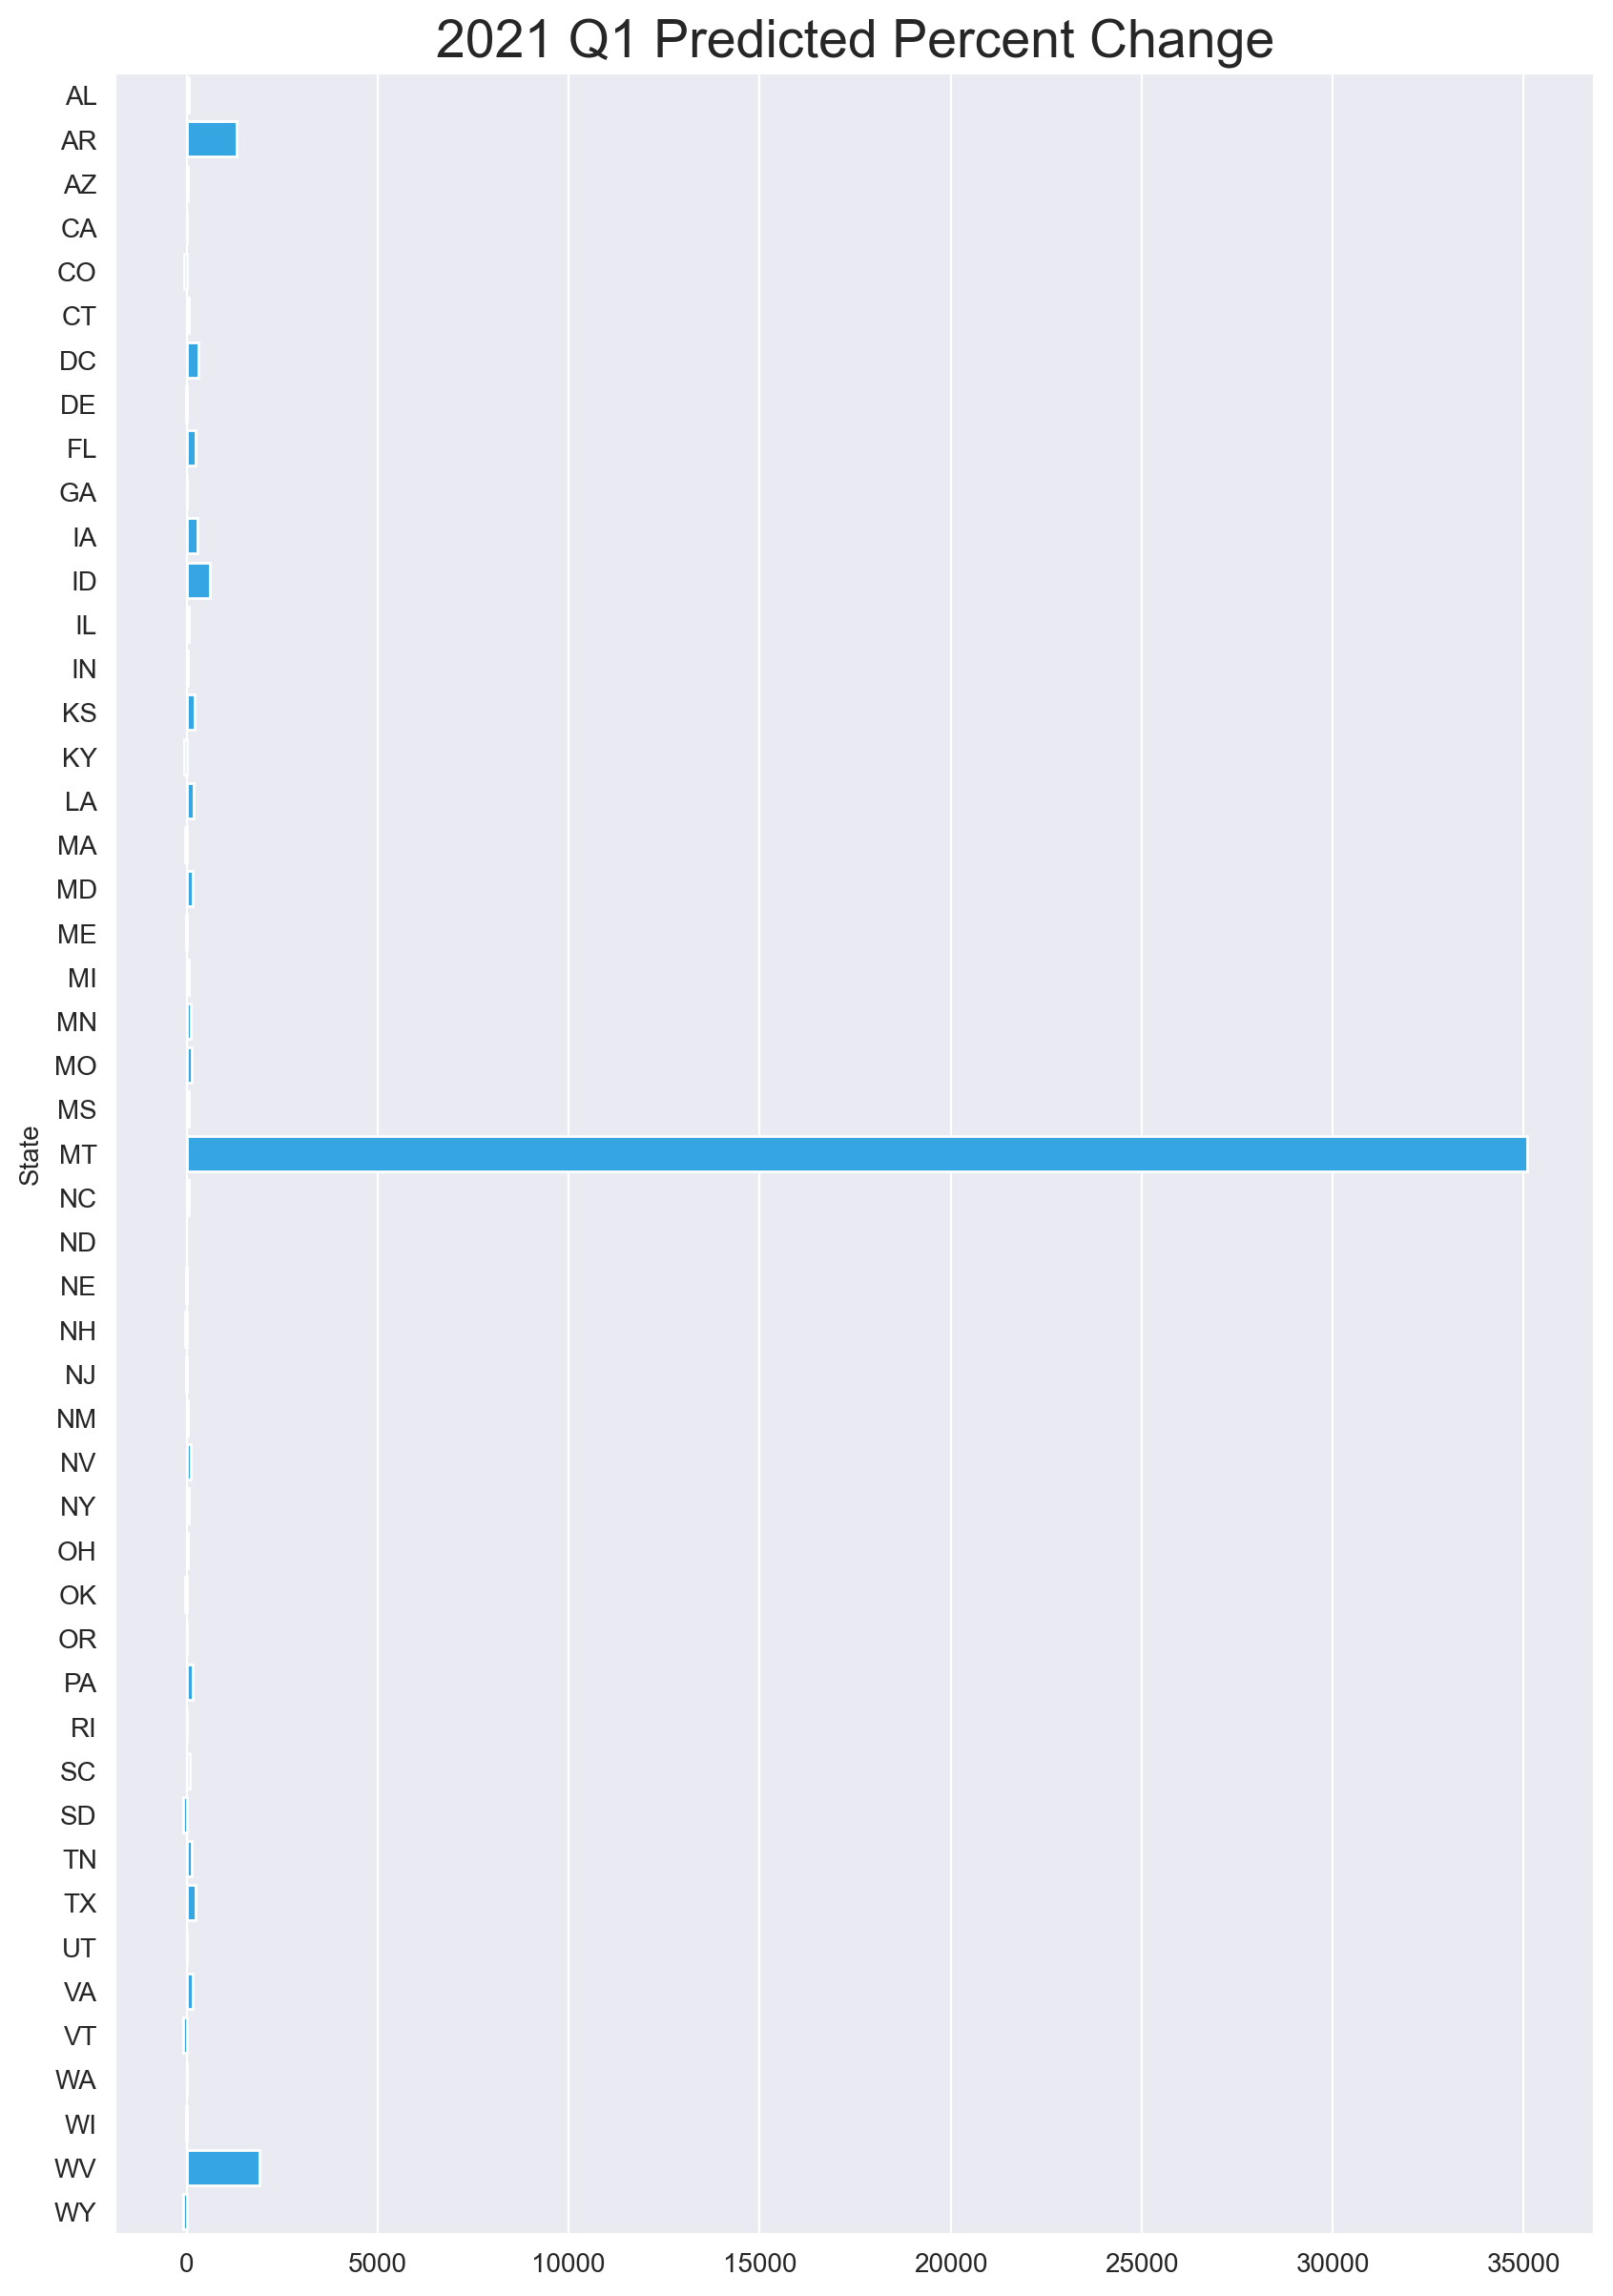

In [75]:
plt.figure(figsize = (10, 15), dpi = 200)

sns.set_style('darkgrid')
sns.barplot(x = 'percent_change_2021', y = 'State', data = first_quarters, color = '#19AEFF')

plt.title('2021 Q1 Predicted Percent Change', size = 20)
plt.xlabel(None)


plt.savefig("figures/percent_change_2021.jpg", bbox_inches = 'tight')
plt.show()

The data for the state of Montana seems to be a major outlier of the results.

I will check Montana's monthly data to see what happened.

In [49]:
MT = state['MT'].resample(rule = 'M').sum()
MT = MT.append(final_forecast['MT'].resample(rule = 'M').sum())

In [50]:
MT

2018-01-31     22
2018-02-28     52
2018-03-31      4
2018-04-30     13
2018-05-31      4
2018-06-30      2
2018-07-31      1
2018-08-31      3
2018-09-30      5
2018-10-31      8
2018-11-30      8
2018-12-31     11
2019-01-31     22
2019-02-28     41
2019-03-31     16
2019-04-30     10
2019-05-31      5
2019-06-30      6
2019-07-31      9
2019-08-31      5
2019-09-30      6
2019-10-31     13
2019-11-30     10
2019-12-31      2
2020-01-31      5
2020-02-29      2
2020-03-31      0
2020-04-30      0
2020-05-31      0
2020-06-30      2
2020-07-31      0
2020-08-31      0
2020-09-30    114
2020-10-31    565
2020-11-30    706
2020-12-31    774
2021-01-31    837
2021-02-28    758
2021-03-31    868
Freq: M, Name: MT, dtype: int64

In [54]:
MT.index

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31'],
              dtype='datetime64[ns]', freq='M')

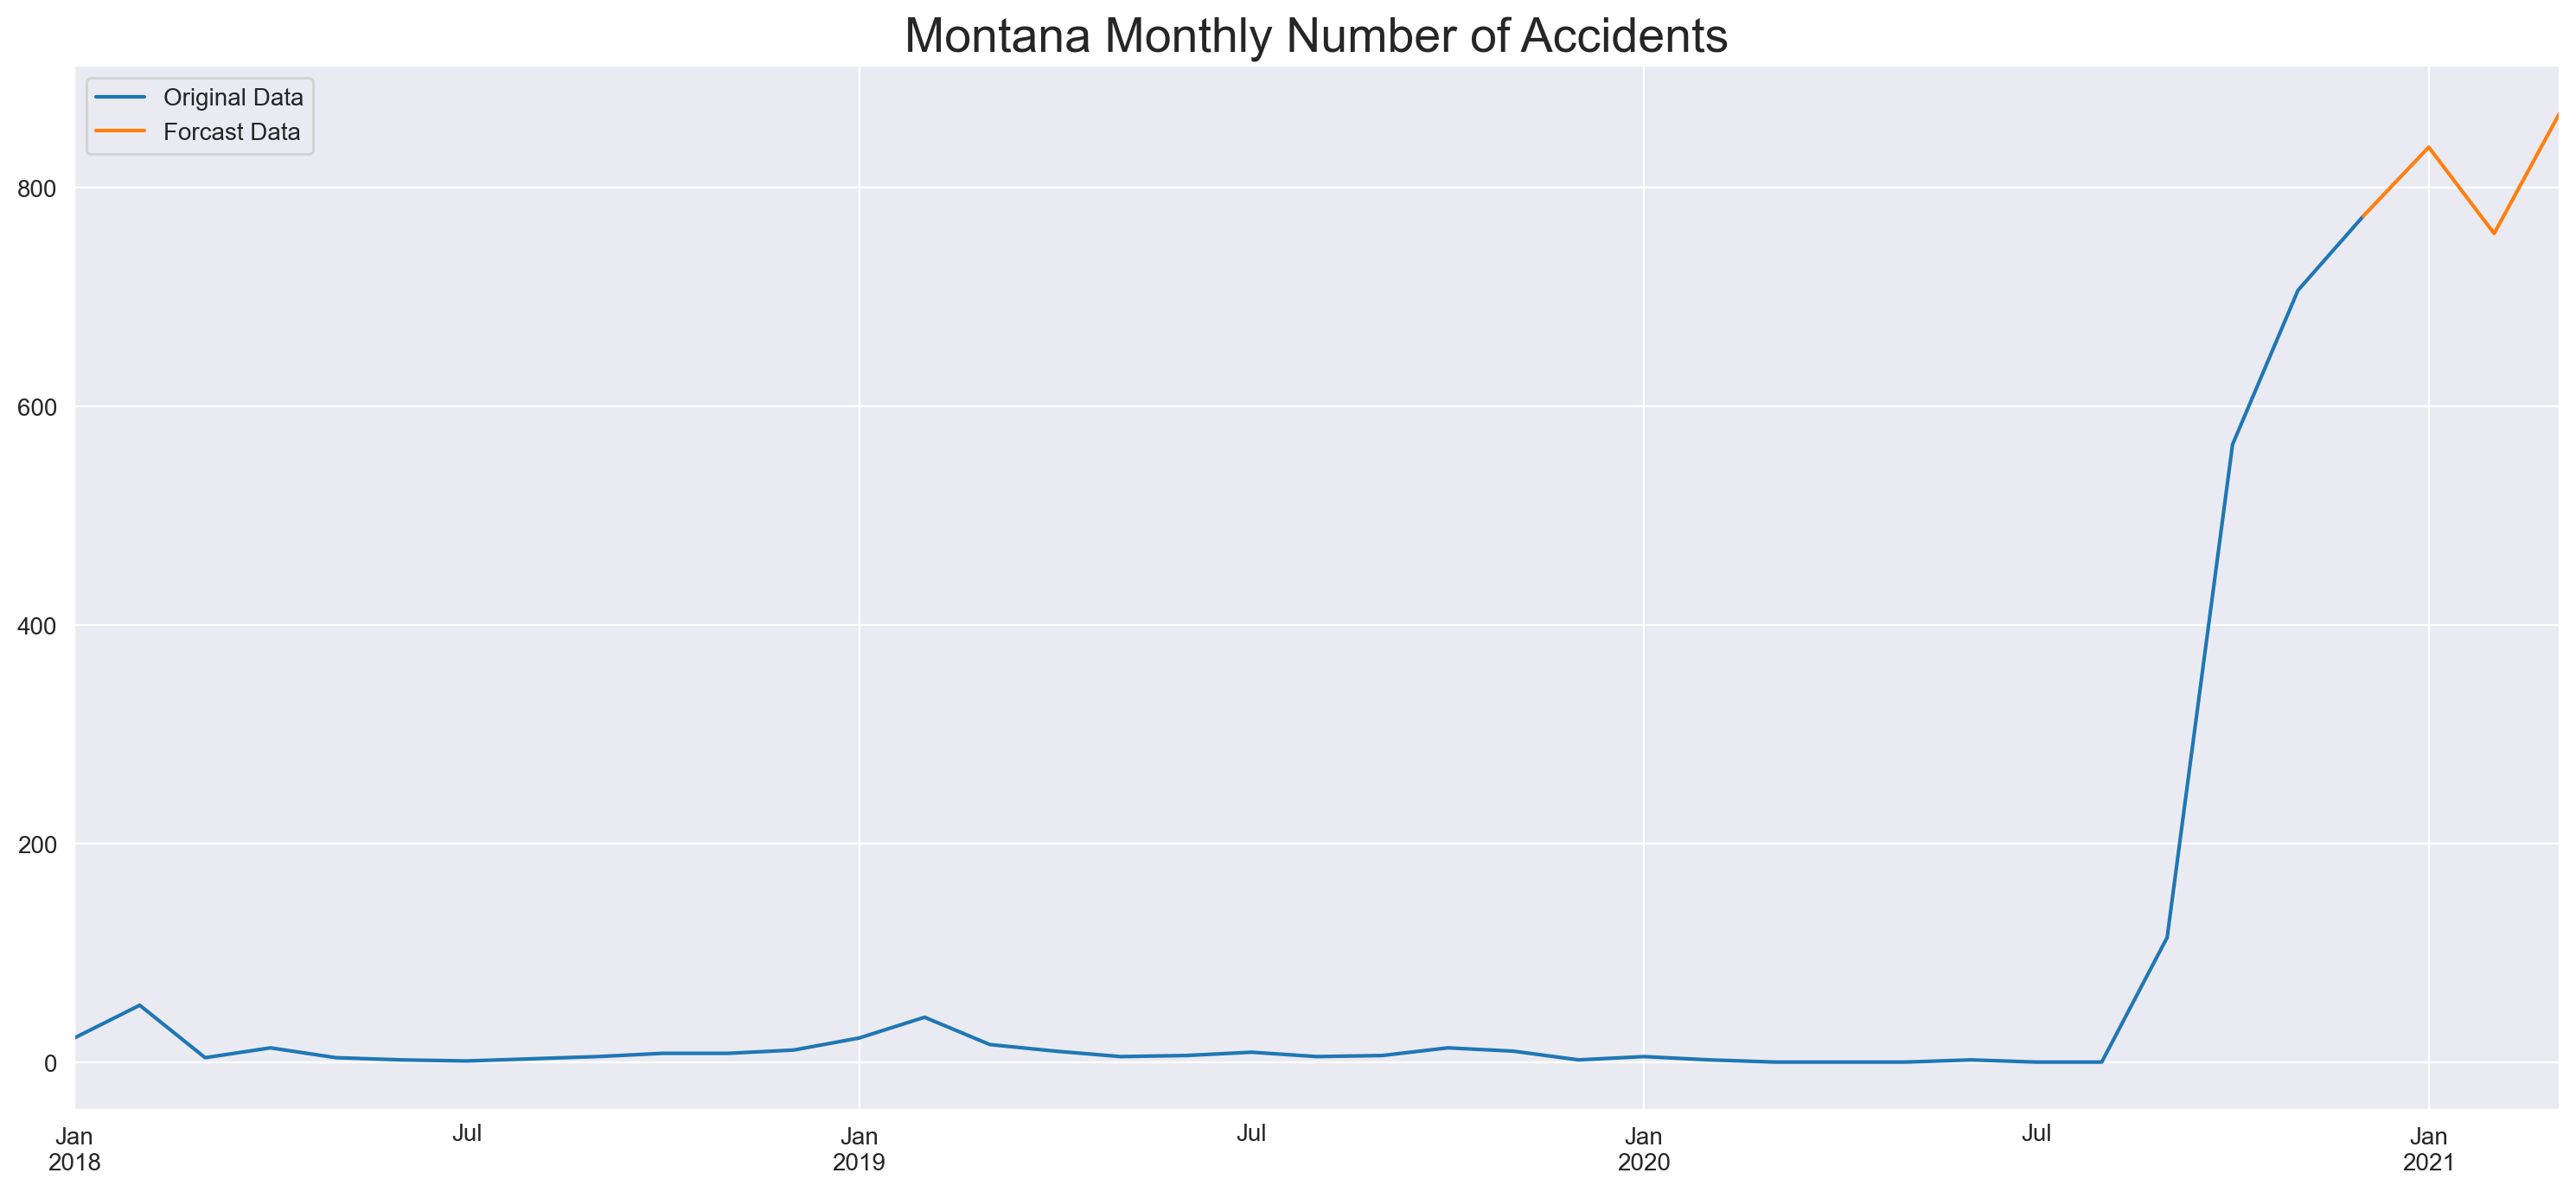

In [73]:
plt.figure(figsize = (15, 7), dpi = 200)
MT.loc[:"2020-12-31"].plot(label = "Original Data")
MT.loc["2020-12-31":].plot(label = "Forcast Data")
plt.title("Montana Monthly Number of Accidents", size = 20)
plt.legend()
plt.savefig("figures/montana.jpg")
plt.tight_layout()
plt.show()

This anomaly may be due to a change in the way the data was collected.  I will leave that state out for now to finish concluding the forecast.

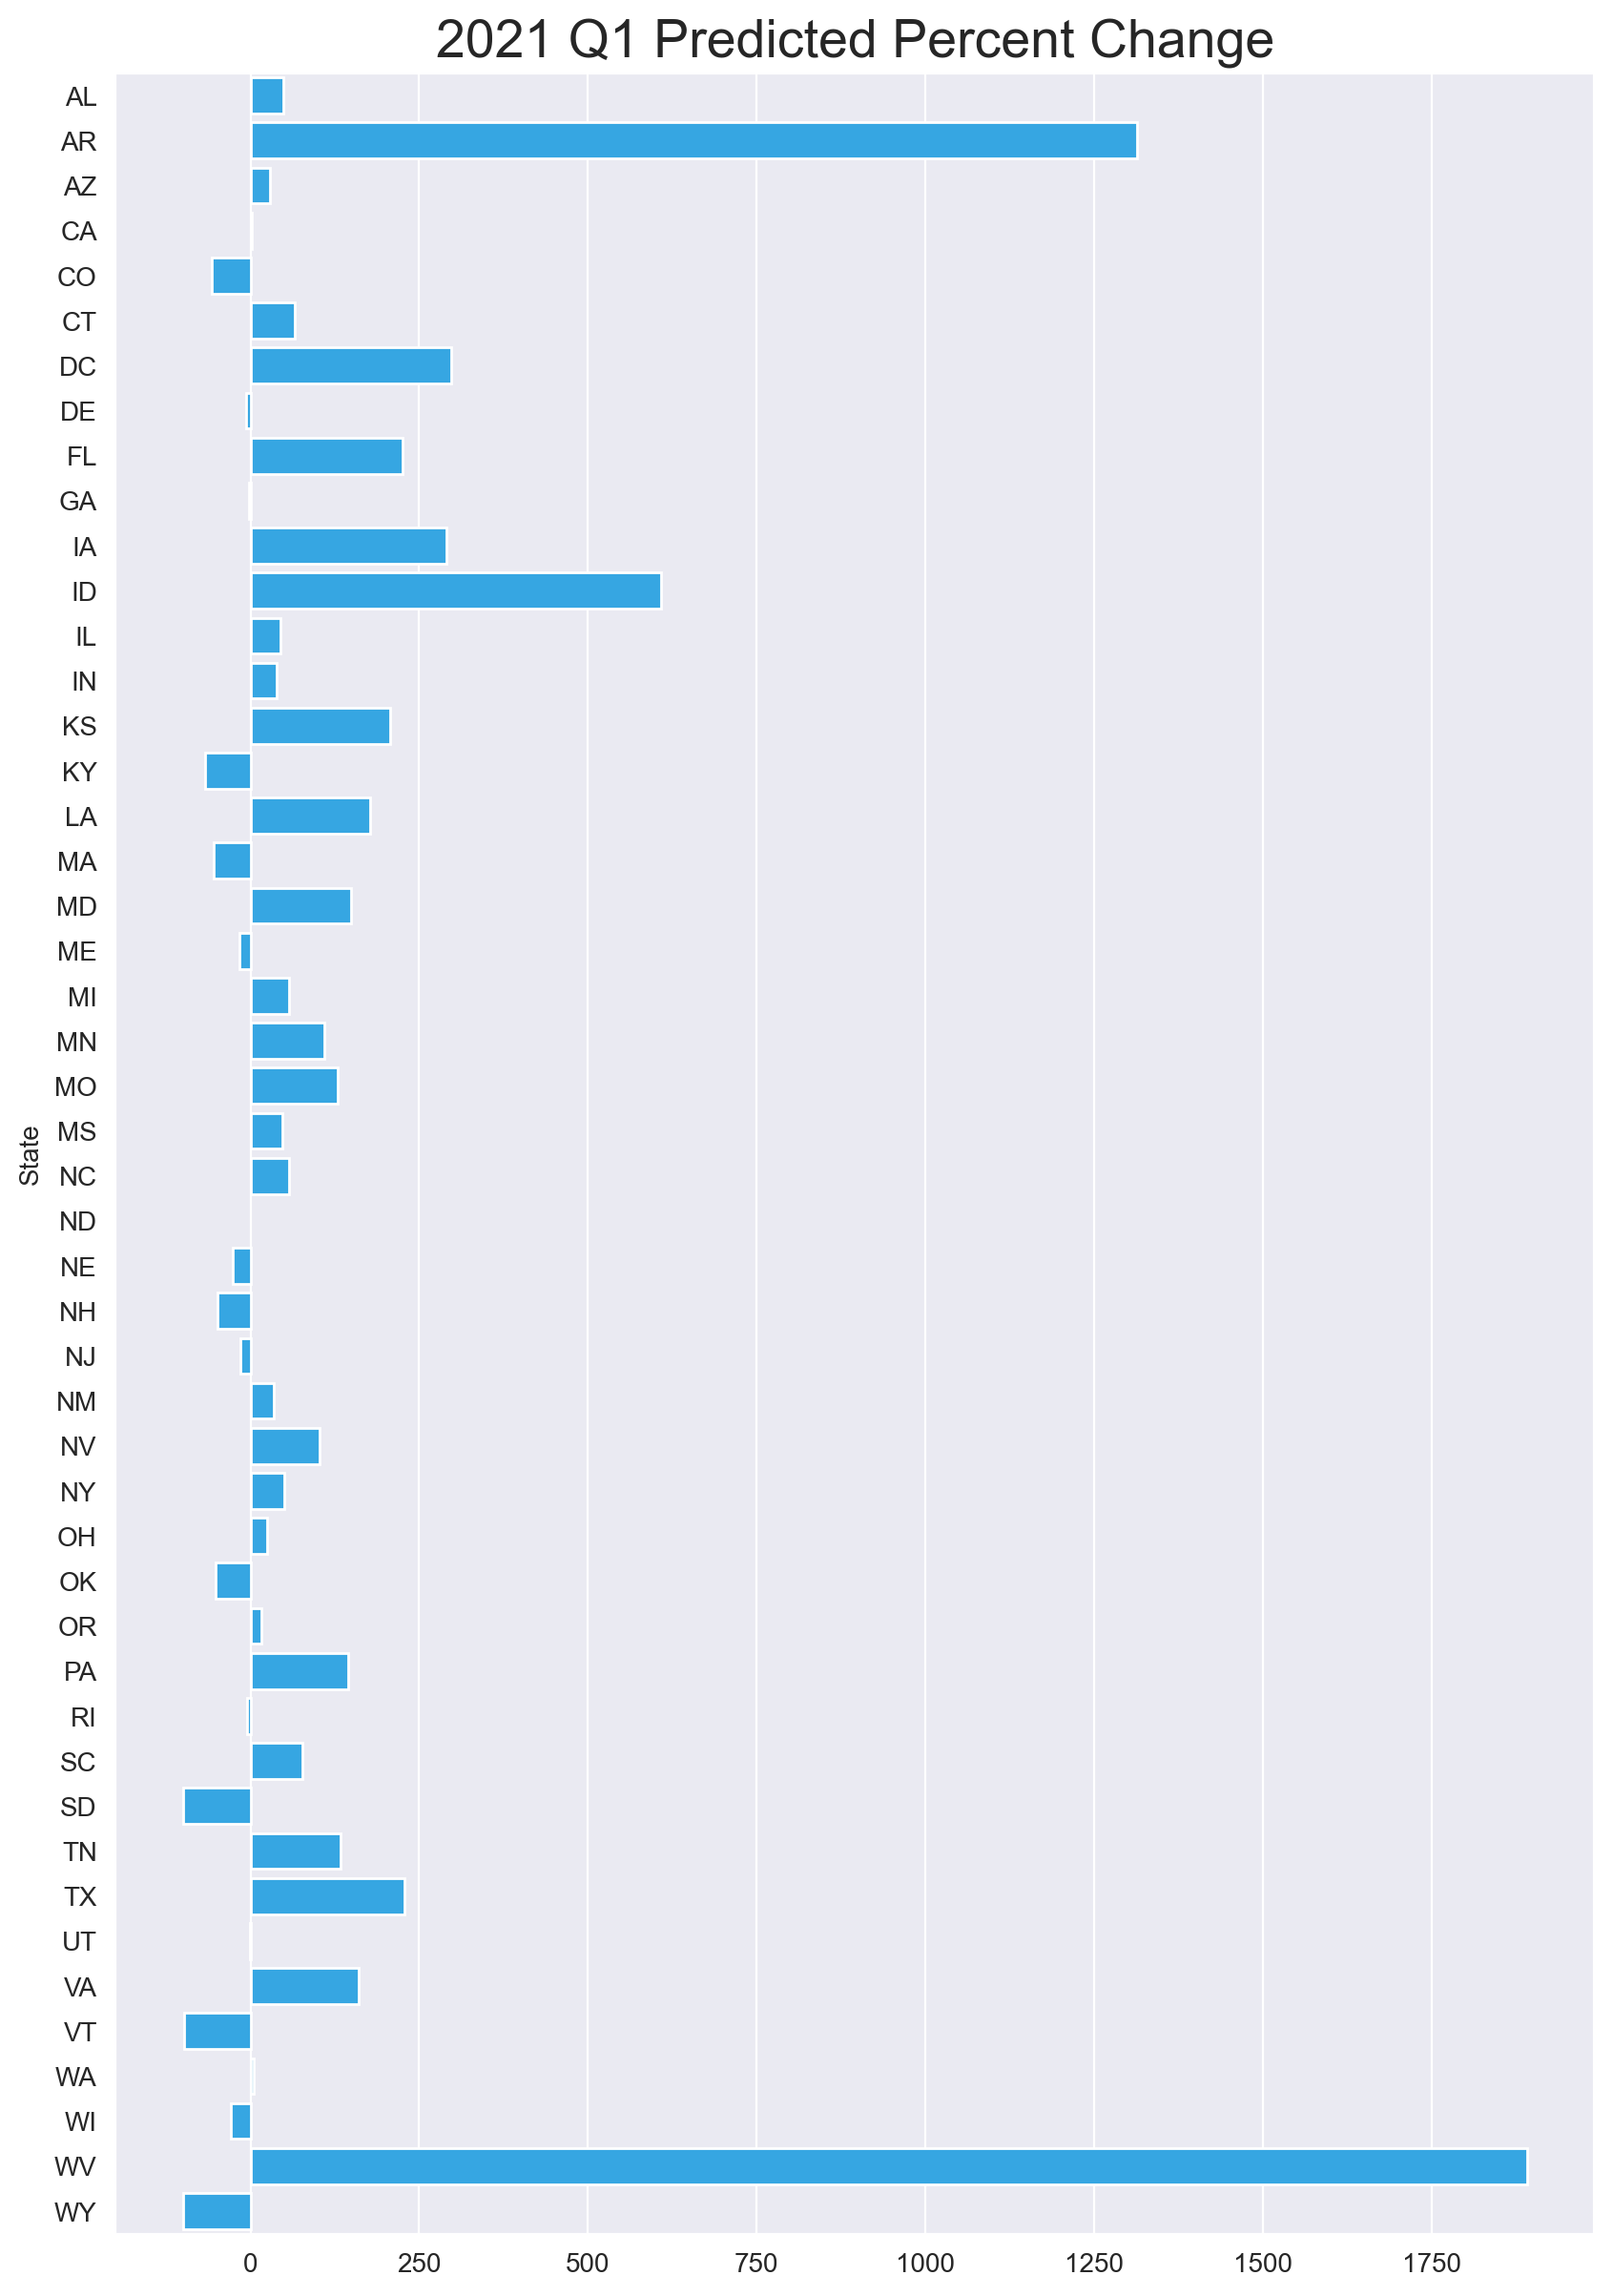

In [74]:
plt.figure(figsize = (10, 15), dpi = 200)

sns.set_style('darkgrid')
sns.barplot(x = 'percent_change_2021', y = 'State', data = first_quarters[first_quarters.State != 'MT'], color = '#19AEFF')

plt.title('2021 Q1 Predicted Percent Change', size = 20)
plt.xlabel(None)


plt.savefig("figures/percent_change_2021_02.jpg", bbox_inches = 'tight')
plt.show()

Some states are predicted to have a significant increase of the number of accidents in the first quarter of 2021 compared to the first quarter of 2020.  This increase could be due to the fact that in 2020 there was a significant decrease of the number of accidents compared to the previous year, in 2019.  The picture below shows that percent change.

<img src = "figures/percent_change_2020.jpg">


To understand better, in a future project it would be nice to see how state wide rules, such as covid protocols, from each individual state may have affected the regular day to day life in those states in both the first quarter of 2020 and 2021.

### The End.